In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import binary_erosion
import fnmatch
import torch
from train.testing import testing
from data_processing.dataset_3d import load_dataset_3d
from data_processing.obj2py import read_get, read_mat, read_egt
from data_processing.helper import sort_filenames, erode_lung_masks
import copy
from plotting_helper import *

In [2]:
eit_path = 'outputs/2024-08-15/15-02-35'
model, cfg = load_model(eit_path)

In [3]:
cfg.learning.training.device = 'cuda:2'

In [4]:
cases = get_all_cases(cfg, base_dir='')    
train_dataset, val_dataset, test_dataset = load_dataset_3d(cases,
            resolution=cfg.data.resolution, 
            base_dir = '',
            raw_data_folder=cfg.data.raw_data_folder, 
            processed_data_folder=cfg.data.processed_data_folder,
            dataset_data_folder=cfg.data.dataset_data_folder,
            name_prefix=cfg.data.name_prefix,
            write_dataset=True, write_npz=False, 
            overwrite_npz=False, n_sample_points=cfg.learning.training.sample_points,
            return_electrodes=cfg.data.return_electrodes, apply_rotation=cfg.data.apply_rotation,
            apply_subsampling=cfg.data.apply_subsampling,
            apply_translation = cfg.data.apply_translation,
            translation_x=cfg.data.translation_x, translation_y=cfg.data.translation_y, translation_z=cfg.data.translation_z,
            point_levels_3d=cfg.data.point_levels_3d, point_range_3d=cfg.data.point_range_3d,
            multi_process=cfg.data.multi_process, num_workers=cfg.data.num_workers, all_signals=cfg.data.all_signals,
            use_body_mask = cfg.learning.model.use_body_mask, signal_norm='all'
            )
test_dataset.case_files = sort_filenames(test_dataset.case_files)

0it [00:00, ?it/s]

237it [00:59,  3.97it/s]

Training set: 852, validation set: 96, test set: 120


In [10]:
targets_model, preds_model, _ = testing(model, test_dataset, batch_size=1, device=cfg.learning.training.device, model_3d=cfg.data.model_3d, point_levels_3d=cfg.data.point_levels_3d, wandb_log=False, point_chunks=8, electrode_level_only=True)

  0%|          | 0/120 [00:00<?, ?it/s]

100%|██████████| 120/120 [02:13<00:00,  1.12s/it]


Test Loss:  tensor(0.0087)
Test Lung Loss:  tensor(0.0009)


/home/nibdombe/deep_eit/train/testing.py:73: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025847130/work/aten/src/ATen/native/IndexingUtils.h:27.)
  test_lung_loss = test_loss[lung_masks].mean()


In [ ]:
preds, targets, lung_masks = pred_postprocess(preds_model, targets_model, nlevel=4)

In [ ]:
# number of figures
n_cases = preds.shape[0]
# number of columns
n_res = preds.shape[1]
# number of rows
n_level = preds.shape[2]

for case in range(n_cases):
    # if case == 1:
    #     break
    for res in range(n_res):
        fig, axes = plt.subplots(n_level, 2, figsize=(10, int(4*n_level)))
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
            
        for level in range(n_level):
            if level == 0:
                axes[level,0].set_title('Ground Truth')
                axes[level,1].set_title('Model Tomogram')
            # GT
            t = remove_empty_space(targets[case,res,level])
            axes[level,0].imshow(t, vmin=0, vmax=0.7, cmap=cmap)       
            axes[level,0].axis('off')
            # Pred + Mask
            cond_value = np.mean(targets[case,res,level][lung_masks[case,res,level]==1])
            p, m = remove_empty_space(preds[case,res,level], lung_masks[case,res,level])
            axes[level,1].imshow(p, vmin=0, vmax=0.7, cmap=cmap)
            axes[level,1].imshow(m, cmap='Greys', alpha=0.3)
            axes[level,1].axis('off')
            plot_lung_contour(p, m, cond_value, axes[level,1])

        # Add colorbar to the figure
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_clim(0, 0.7)
        cbar = fig.colorbar(sm, cax=cbar_ax)        
        cbar.set_label('Conductivity (S/m)')
        fig.suptitle(f'{test_dataset.cases[int(case/4)]}')
        plt.show()
        plt.close(fig)


## Get Metrics for each Resistivity used

In [ ]:
loss = []
loss_lung = []
for res in [5,10,15,20]:
    test_dataset_tmp = copy.deepcopy(test_dataset)
    test_dataset_tmp.case_files = [case for case in test_dataset_tmp.case_files if fnmatch.fnmatch(case, f'*_{res}.npz')]
    test_loss, test_lung_loss = testing(model, test_dataset_tmp, batch_size=1, device=cfg.learning.training.device, model_3d=cfg.data.model_3d, point_levels_3d=cfg.data.point_levels_3d, wandb_log=False, point_chunks=8, electrode_level_only=True, return_loss=True)
    loss.append(test_loss)
    loss_lung.append(test_lung_loss)

100%|██████████| 30/30 [00:26<00:00,  1.11it/s]


Test Loss:  tensor(0.0076)
Test Lung Loss:  tensor(0.0012)


100%|██████████| 30/30 [00:26<00:00,  1.12it/s]


Test Loss:  tensor(0.0083)
Test Lung Loss:  tensor(0.0009)


100%|██████████| 30/30 [00:26<00:00,  1.12it/s]


Test Loss:  tensor(0.0086)
Test Lung Loss:  tensor(0.0010)


100%|██████████| 30/30 [00:26<00:00,  1.12it/s]


Test Loss:  tensor(0.0088)
Test Lung Loss:  tensor(0.0011)


## Noise Robustness

In [ ]:
# choose noise level
set_seed(123)
snrs_low = [60, 0, -10, -20]
snrs_high = [90, 30, 0, -10]
n_noise = len(test_dataset)

test_dataset_noise = []

for i in range(n_noise):
    for snr_high in snrs_high:
        for snr_low in snrs_low:
            noise = sample_noise(snr_low, snr_high).reshape(4,208)
            test_dataset_noise.append(noise)
test_dataset_noise = np.stack(test_dataset_noise, axis=0).reshape(n_noise, len(snrs_high), len(snrs_low), 4, 208)


In [ ]:
loss_list = []
lung_loss_list = []
for i in range(len(snrs_high)):
    # for j in range(len(snrs_low)):
    test_dataset_copy = copy.deepcopy(test_dataset)
    noise = torch.from_numpy(test_dataset_noise[:,i,i])
    test_loss, test_lung_loss = testing(model, test_dataset_copy, batch_size=1, device=cfg.learning.training.device, model_3d=cfg.data.model_3d, point_levels_3d=cfg.data.point_levels_3d, wandb_log=False, point_chunks=8, noise=noise, electrode_level_only=True, return_loss=True)
    loss_list.append(test_loss)
    lung_loss_list.append(test_lung_loss)

  0%|          | 0/120 [00:00<?, ?it/s]


RuntimeError: shape '[1, -1, 9, 512, 512, 3]' is invalid for input of size 11796480

# Single Case 

In [79]:
case = 'case_TCIA_401_0'
points_case = []
signals_case = []
electrodes_case = []
masks_case = []
targets_case = []
tissues_case = []

# extract case from the dataloader
for i, data in enumerate(test_dataset):
    if fnmatch.fnmatch(test_dataset.case_files[i], f'{case}*.npz'):
        points, signals, electrodes, masks, targets, tissues = data
        points_case.append(points)
        signals_case.append(signals)
        electrodes_case.append(electrodes)
        # masks_case.append(masks)
        targets_case.append(targets)
        # tissues_case.append(tissues)
    else:
        continue
points_case = torch.stack(points_case, dim=0)
signals_case = torch.stack(signals_case, dim=0)
electrodes_case = torch.stack(electrodes_case, dim=0)
# masks_case = torch.stack(masks_case, dim=0)
targets_case = torch.stack(targets_case, dim=0)
targets_case_raw = targets_case
# tissues_case = torch.stack(tissues_case, dim=0)
nres = signals_case.shape[0]
nlevel = cfg.data.point_levels_3d

In [ ]:
preds_all = []
targets_all = []

points = points_case.reshape(4, -1, cfg.data.point_levels_3d, 512, 512, 3)
target = targets_case.reshape(4, -1, cfg.data.point_levels_3d, 512, 512, 1)
levels = torch.arange(cfg.data.point_levels_3d)        
electrode_levels = torch.linspace(levels[1],levels[-2],4).numpy().astype(int)
points = points[:,:,electrode_levels].reshape(4, -1, 3)
target = target[:,:,electrode_levels].reshape(4, -1, 1)

for i in range(points.shape[0]):
    _, pred, _ = testing(model, [signals_case[i].unsqueeze(0).float(), 
                              electrodes_case[i].unsqueeze(0).float(), 
                              points[i].unsqueeze(0).float()], 
                              batch_size=1, 
                              device=cfg.learning.training.device, 
                              wandb_log=False, 
                              electrode_level_only=True,
                              point_levels_3d=cfg.data.point_levels_3d)
    targets_all.append(target[i].detach().cpu().squeeze())
    preds_all.append(pred.detach().cpu().squeeze())
preds_all = torch.concatenate(preds_all, axis=0)
targets_all = torch.concatenate(targets_all, axis=0)
preds_case, targets_case, lung_masks_case = pred_postprocess(preds_all, targets_all, resolution=512, nres=nres, nlevel=4)
preds_case, targets_case, lung_masks_case = preds_case.squeeze(0), targets_case.squeeze(0), lung_masks_case.squeeze(0)

In [ ]:
nlevel = 4

In [ ]:
for i in range(nres):
    fig, axes = plt.subplots(4, 2, figsize=(10, int(4*4)))
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    for level in range(nlevel):
        if level == 0:
            axes[level,0].set_title('Ground Truth')
            axes[level,1].set_title('Model Tomogram')
        # GT
        target = remove_empty_space(targets_case[i,level])
        axes[level,0].imshow(target, vmin=0, vmax=0.7, cmap=cmap)       
        axes[level,0].axis('off')
        # Pred + Mask
        cond_value = np.mean(targets_case[i,level][lung_masks_case[i,level]==1])
        p, m = remove_empty_space(preds_case[i,level], lung_masks_case[i,level])
        axes[level,1].imshow(p, vmin=0, vmax=0.7, cmap=cmap)
        axes[level,1].imshow(m, cmap='Greys', alpha=0.3)
        axes[level,1].axis('off')
        plot_lung_contour(p, m, cond_value, axes[level,1])

    # Add colorbar to the figure
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_clim(0, 0.7)
    cbar = fig.colorbar(sm, cax=cbar_ax)        
    cbar.set_label('Conductivity (S/m)')
    # fig.suptitle(f'{test_dataset.cases[i]}')
    plt.show()
    plt.close(fig)
    plt.tight_layout()


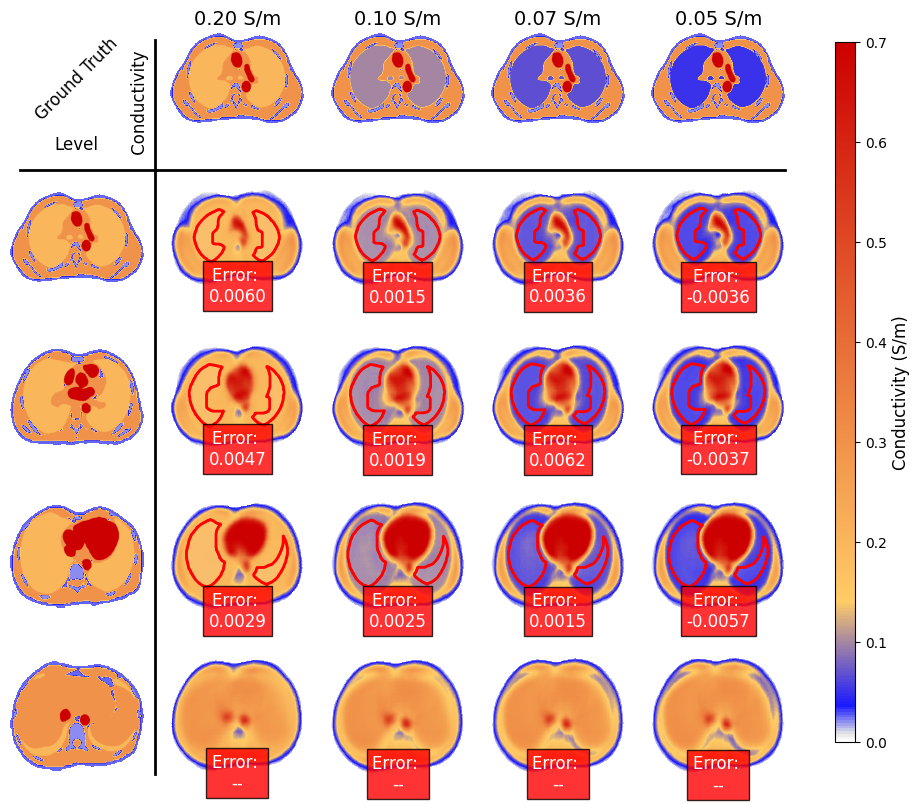

In [ ]:
ncols = nres+1
nrows = nlevel+1
# set up figure
fig, axes = plt.subplots(nrows, ncols, figsize=(int((ncols)*2), int(2*nrows)))
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
axes[0,0].text(0.5, 0.5, 'Ground Truth', ha='center', va='center', rotation=45)
axes[0,0].text(0.5, 0., 'Level', ha='center', va='center', rotation=0)
axes[0,0].text(0.97, 0.3, ' Conductivity', ha='center', va='center', rotation=90)
axes[0,0].axis('off')

for level in range(nlevel):
    # GT across levels (choose cond. 0.05)
    t = remove_empty_space(targets_case[0,level])
    axes[level+1,0].imshow(t, vmin=0, vmax=0.7, cmap=cmap)       
    axes[level+1,0].axis('off')
    for res in range(nres):
        cond_value = np.mean(targets_case[res,level][lung_masks_case[i,level]==1])
        # GT across cond. values (choose level 0)
        if level == 0:
            t = remove_empty_space(targets_case[res,level])
            axes[0,res+1].imshow(t, vmin=0, vmax=0.7, cmap=cmap)       
            axes[0,res+1].axis('off')
            axes[level,int(res+1)].set_title(f'{cond_value:.2f} S/m')
        p, m = remove_empty_space(preds_case[res,level], lung_masks_case[res,level])
        axes[level+1,res+1].imshow(p, vmin=0, vmax=0.7, cmap=cmap)
        axes[level+1,res+1].imshow(m, cmap='Greys', alpha=0.1)
        axes[level+1,res+1].axis('off')
        plot_lung_contour(p, m, cond_value, axes[level+1,res+1])

        axes[level+1,res+1].axis('off')
        axes[level+1,res+1].set_facecolor('grey')

# Add colorbar to the figure
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(0, 0.7)
cbar = fig.colorbar(sm, cax=cbar_ax)        
cbar.set_label('Conductivity (S/m)')

# Draw horizontal and vertical lines separating the lower right 4x4 grid
# Use the figure's add_artist method to add lines at the required positions
# Get the positions of the first row and first column of the lower right 4x4 grid
top_left_of_4x4 = axes[1, 1].get_position() 
bottom_right_of_4x4 = axes[nrows-1, ncols-1].get_position()

# Adjusted positions for the lines to be outside the plots
horizontal_line_y = top_left_of_4x4.y1 + 0.0
vertical_line_x = top_left_of_4x4.x0 - 0.0

# Draw a horizontal line
fig.add_artist(plt.Line2D([top_left_of_4x4.x0-0.15, bottom_right_of_4x4.x1], 
                        [horizontal_line_y+0.02, horizontal_line_y+0.02], 
                        color='black', linewidth=2))

# Draw a vertical line
fig.add_artist(plt.Line2D([vertical_line_x-0.015, vertical_line_x-0.015], 
                        [bottom_right_of_4x4.y0, top_left_of_4x4.y1+0.15], 
                        color='black', linewidth=2))
                        
# fig.suptitle(f'{test_dataset.cases[int(i/4)]}', fontsize=fontsize)
# plt.tight_layout()
plt.show()
plt.close(fig)


# Noise Robustness

/scratch/tmp/nibdombe/ipykernel_1898/3796717577.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.arange(1, 14))


[Text(-2.0, 0, '1'),
 Text(0.0, 0, '2'),
 Text(2.0, 0, '3'),
 Text(4.0, 0, '4'),
 Text(6.0, 0, '5'),
 Text(8.0, 0, '6'),
 Text(10.0, 0, '7'),
 Text(12.0, 0, '8'),
 Text(14.0, 0, '9')]

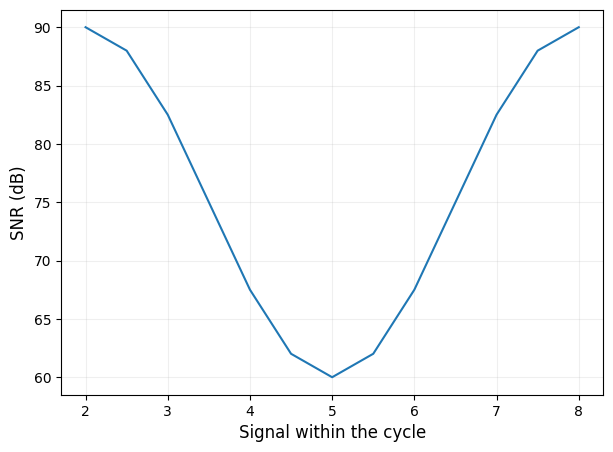

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.grid(alpha=0.2)
ax.plot(generate_cosine_function(90, 60, 13))
ax.set_xlabel('Signal within the cycle')
ax.set_ylabel('SNR (dB)')
ax.set_xticklabels(np.arange(1, 14))

In [17]:
set_seed(123)

snrs_low = [60, 0, -10, -20]
snrs_high = [90, 30, 0, -10]

signal_noise_all = []
preds_all = []
targets_all = []

# choose level and res 
level = 1
res = 3

electrodes = electrodes_case[res]
signals = signals_case[res]
points = points_case[res]

for snr_low in snrs_low:
    for snr_high in snrs_high:
        noise = sample_noise(snr_low, snr_high).reshape(signals.shape)
        signals_noise = signals + noise

        _, pred, _ = testing(model, [signals_noise.unsqueeze(0).float(), 
                                electrodes.unsqueeze(0).float(), 
                                points.unsqueeze(0).float()], 
                                batch_size=1, device=cfg.learning.training.device, wandb_log=False,)
        targets_all.append(torch.from_numpy(targets_case[res, level]))
        preds_all.append(pred.detach().cpu().squeeze()[level])
        signal_noise_all.append(signals_noise)
preds_all = torch.stack(preds_all, axis=0)
targets_all = torch.stack(targets_all, axis=0)
signal_noise_all = np.stack(signal_noise_all, axis=0)
preds_all = preds_all.reshape(len(snrs_low), len(snrs_high), 512, 512)
targets_all = targets_all.reshape(len(snrs_low), len(snrs_high), 512, 512)

In [19]:
# postprocess
cond_value = 0.05
preds, targets, lung_masks = pred_postprocess(preds_all, targets_all, resolution=512, nlevel=len(snrs_high), nres=len(snrs_low), cond_value=cond_value)
preds, targets, lung_masks = preds[0], targets[0], lung_masks[0]
# manually postprocess lung mask (didn't work for some reason?)
resolution = 512
lung_mask = targets_all[:,0]==cond_value
lung_mask = lung_mask.unsqueeze(1).tile(1, len(snrs_high), 1, 1, 1).reshape(-1, resolution, resolution).numpy()
lung_mask_shrunken = torch.tensor([binary_erosion(mask, structure=np.ones((30,30))).astype(np.uint8) for mask in lung_mask])
lung_mask_shrunken = lung_mask_shrunken.reshape(-1, len(snrs_high), len(snrs_high), resolution, resolution)

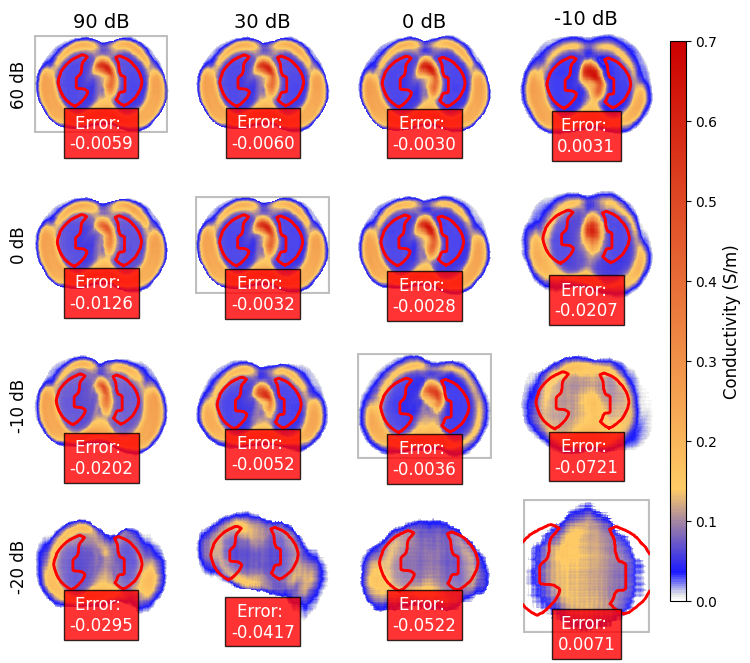

In [23]:
nrows = len(snrs_low)
ncols = len(snrs_high)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
for i in range(nrows):
    for j in range(ncols):
        p, m = remove_empty_space(preds[i,j], lung_mask_shrunken.numpy()[0,i,j])
        axes[i,j].imshow(p, cmap=cmap, vmin=0, vmax=0.7)
        axes[i,j].imshow(m, cmap='Greys', alpha=0.1)
        plot_lung_contour(p, m, cond_value, axes[i,j])
        if i == 0:
            axes[i,j].set_title(f'{snrs_high[j]} dB')
        if j == 0:
            # Hide x-axis and y-axis ticks and tick labels
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

            # Hide the spines (the lines bounding the plot area)
            axes[i,j].spines['top'].set_visible(False)
            axes[i,j].spines['bottom'].set_visible(False)
            axes[i,j].spines['left'].set_visible(False)
            axes[i,j].spines['right'].set_visible(False)
            axes[i,j].set_ylabel(f'{snrs_low[i]} dB')
        else:
            axes[i,j].axis('off')
        if i==j:
            # Create a rectangle patch
            rect = patches.Rectangle((0, 0), 1, 1, transform=axes[i,j].transAxes,
                                    color='grey', alpha=0.5, zorder=0, fill=False, linewidth=3)
            # Add the rectangle to the subplot
            axes[i,j].add_patch(rect)
# Add colorbar to the figure
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(0, 0.7)
cbar = fig.colorbar(sm, cax=cbar_ax)        
cbar.set_label('Conductivity (S/m)')

In [24]:
signal_noise_all = signal_noise_all.reshape(len(snrs_low), len(snrs_high), 4, 16, 13)
signal_gt = signals_case.reshape(4, 4, 16, 13)[3].numpy()

signal_noise_all_rescaled = signal_noise_all * test_dataset.train_std.unsqueeze(0).numpy() + test_dataset.train_mean.unsqueeze(0).numpy()
signal_gt_rescaled = signal_gt * test_dataset.train_std.squeeze().numpy() + test_dataset.train_mean.squeeze().numpy()

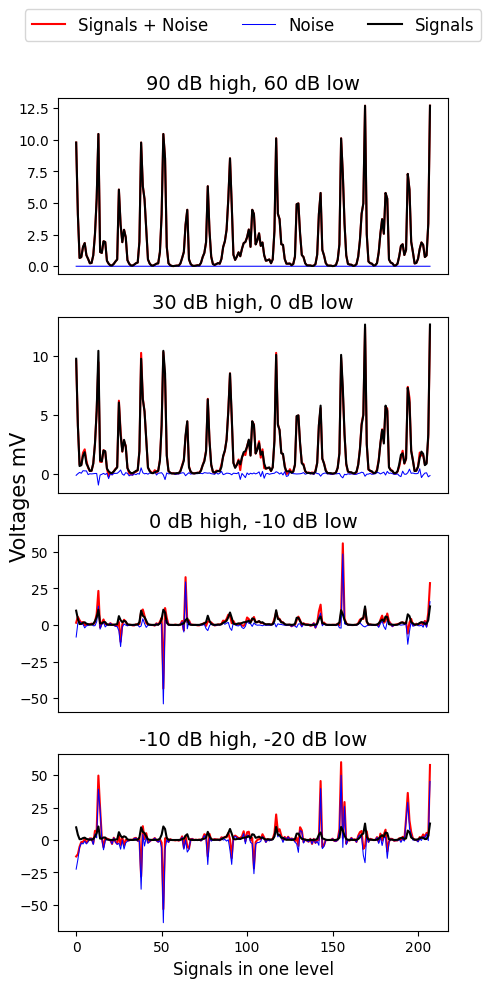

In [25]:
fig, axes = plt.subplots(len(snrs_low), 1, figsize=(5, 2.5*len(snrs_low)))#, sharex=True)
for i in range(len(snrs_low)):
    axes[i].plot(signal_noise_all_rescaled[i,i,0].reshape(-1), label=f'Signals + Noise', color='red')#, linestyle='dashed')
    axes[i].plot(signal_noise_all_rescaled[i,i,0].reshape(-1)-signal_gt_rescaled[0].reshape(-1), label='Noise', color='blue', linewidth=0.75)#, linestyle='dashed')
    axes[i].set_title(f'{snrs_high[i]} dB high, {snrs_low[i]} dB low')
    axes[i].plot(signal_gt_rescaled[0].reshape(-1), label='Signals', color='black')
    # axes[i].set_ylim(-2, 13)
    if i == len(snrs_low)-1:
        axes[i].set_xlabel('Signals in one level')
    else:
        axes[i].set_xticks([])
    if i == 0:
        axes[i].legend(loc='upper center', bbox_to_anchor=(.5, 1.5), borderaxespad=0., ncol=3)
fig.text(0.04, 0.5, 'Voltages mV', va='center', ha='center', fontsize=15, rotation='vertical')
plt.tight_layout()


## Test robustness for different cycle dropouts

In [29]:
paths_dropout = ['outputs/2024-08-01/19-04-02','outputs/2024-08-01/19-04-07', 'outputs/2024-08-01/19-04-13', 'outputs/2024-08-01/19-04-19']

signal_noise_all = []
preds_all = []
targets_all = []

for path in paths_dropout:
    set_seed(123)
    eit_path = path
    model, cfg = load_model(eit_path)

    # choose level and res 
    level = 1
    res = 3

    electrodes = electrodes_case[res]
    signals = signals_case[res]
    points = points_case[res]

    for snr_low in snrs_low:
        for snr_high in snrs_high:
            noise = sample_noise(snr_low, snr_high).reshape(signals.shape)
            signals_noise = signals + noise

            _, pred, _ = testing(model, [signals_noise.unsqueeze(0).float(), 
                                    electrodes.unsqueeze(0).float(), 
                                    points.unsqueeze(0).float()], 
                                    batch_size=1, device=cfg.learning.training.device, wandb_log=False,)
            targets_all.append(torch.from_numpy(targets_case[res, level]))
            preds_all.append(pred.detach().cpu().squeeze()[level])
            signal_noise_all.append(signals_noise)
preds_all = torch.stack(preds_all, axis=0)
targets_all = torch.stack(targets_all, axis=0)
signal_noise_all = np.stack(signal_noise_all, axis=0)
preds_all = preds_all.reshape(4, len(snrs_low), len(snrs_high), 512, 512)
targets_all = targets_all.reshape(4, len(snrs_low), len(snrs_high), 512, 512)


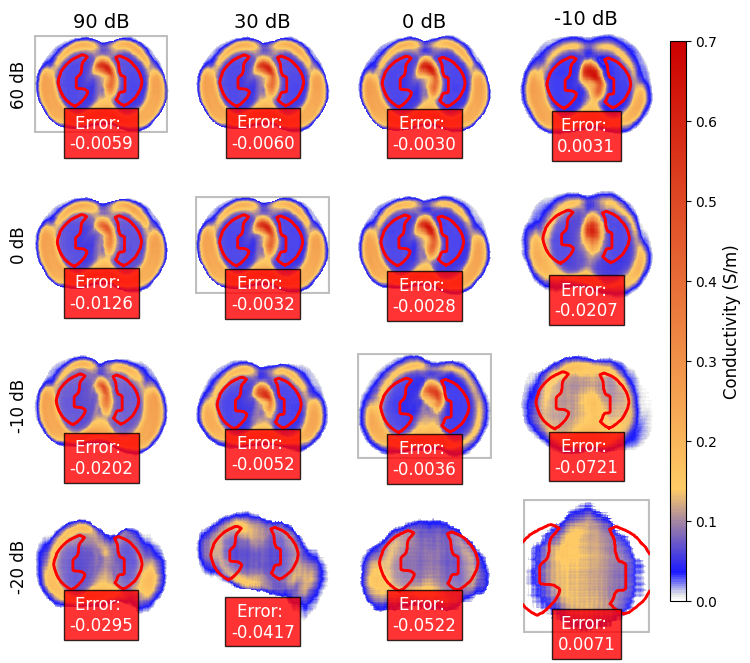

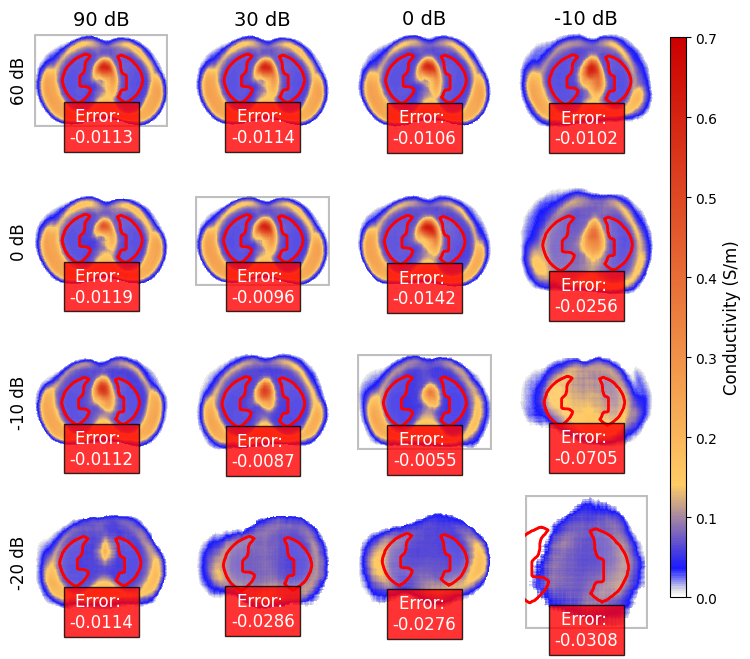

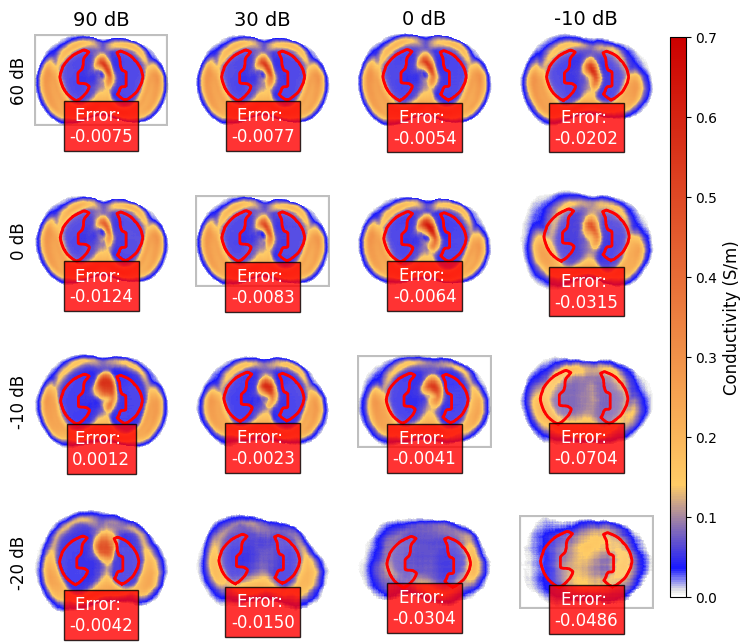

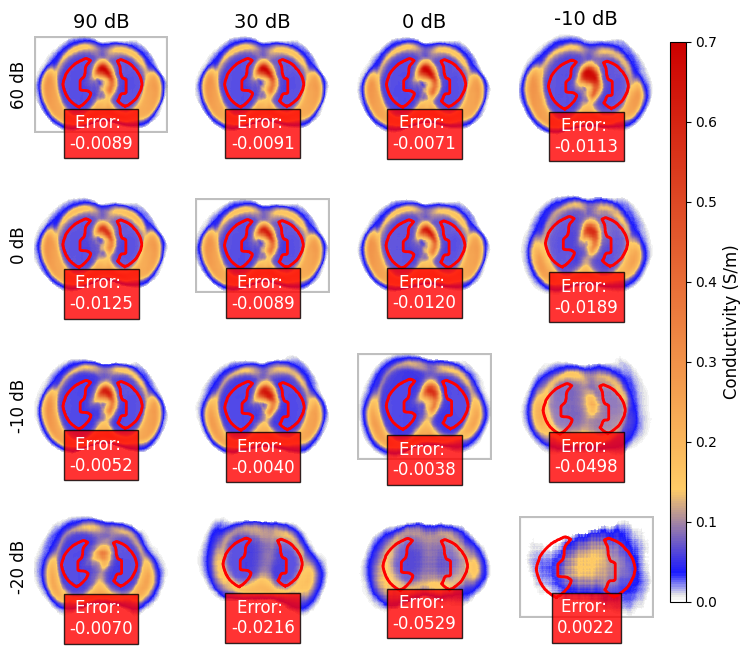

In [32]:
# postprocess
cond_value = 0.05
for p, t in zip(preds_all, targets_all):
    preds, targets, lung_masks = pred_postprocess(p, t, resolution=512, nlevel=len(snrs_high), nres=len(snrs_low), cond_value=cond_value)
    preds, targets, lung_masks = preds[0], targets[0], lung_masks[0]
    # manually postprocess lung mask (didn't work for some reason?)
    resolution = 512
    lung_mask = t[:,0]==cond_value
    lung_mask = lung_mask.unsqueeze(1).tile(1, len(snrs_high), 1, 1, 1).reshape(-1, resolution, resolution).numpy()
    lung_mask_shrunken = torch.tensor([binary_erosion(mask, structure=np.ones((30,30))).astype(np.uint8) for mask in lung_mask])
    lung_mask_shrunken = lung_mask_shrunken.reshape(-1, len(snrs_high), len(snrs_high), resolution, resolution)

    nrows = len(snrs_low)
    ncols = len(snrs_high)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    for i in range(nrows):
        for j in range(ncols):
            p, m = remove_empty_space(preds[i,j], lung_mask_shrunken.numpy()[0,i,j])
            axes[i,j].imshow(p, cmap=cmap, vmin=0, vmax=0.7)
            axes[i,j].imshow(m, cmap='Greys', alpha=0.1)
            plot_lung_contour(p, m, cond_value, axes[i,j])
            if i == 0:
                axes[i,j].set_title(f'{snrs_high[j]} dB')
            if j == 0:
                # Hide x-axis and y-axis ticks and tick labels
                axes[i,j].xaxis.set_visible(False)
                axes[i,j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

                # Hide the spines (the lines bounding the plot area)
                axes[i,j].spines['top'].set_visible(False)
                axes[i,j].spines['bottom'].set_visible(False)
                axes[i,j].spines['left'].set_visible(False)
                axes[i,j].spines['right'].set_visible(False)
                axes[i,j].set_ylabel(f'{snrs_low[i]} dB')
            else:
                axes[i,j].axis('off')
            if i==j:
                # Create a rectangle patch
                rect = patches.Rectangle((0, 0), 1, 1, transform=axes[i,j].transAxes,
                                        color='grey', alpha=0.5, zorder=0, fill=False, linewidth=3)
                # Add the rectangle to the subplot
                axes[i,j].add_patch(rect)
    # Add colorbar to the figure
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_clim(0, 0.7)
    cbar = fig.colorbar(sm, cax=cbar_ax)        
    cbar.set_label('Conductivity (S/m)')
    plt.show()

### Test over all test cases

In [38]:
# choose noise level
set_seed(123)
n_noise = len(test_dataset)

test_dataset_noise = []

for i in range(n_noise):
    for snr_high in snrs_high:
        for snr_low in snrs_low:
            noise = sample_noise(snr_low, snr_high).reshape(4,208)
            test_dataset_noise.append(noise)
test_dataset_noise = np.stack(test_dataset_noise, axis=0).reshape(n_noise, len(snrs_high), len(snrs_low), 4, 208)

loss_list = []
lung_loss_list = []
for path in paths_dropout:
    model, cfg = load_model(path)
    for i in range(len(snrs_high)):
        # for j in range(len(snrs_low)):
        test_dataset_copy = copy.deepcopy(test_dataset)
        noise = torch.from_numpy(test_dataset_noise[:,i,i])
        test_loss, test_lung_loss = testing(model, test_dataset_copy, batch_size=1, device=cfg.learning.training.device, model_3d=cfg.data.model_3d, point_levels_3d=cfg.data.point_levels_3d, wandb_log=False, point_chunks=8, noise=noise, electrode_level_only=True, return_loss=True)
        loss_list.append(test_loss)
        lung_loss_list.append(test_lung_loss)

100%|██████████| 120/120 [02:12<00:00,  1.10s/it]
/home/nibdombe/deep_eit/train/testing.py:73: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025847130/work/aten/src/ATen/native/IndexingUtils.h:27.)
  test_lung_loss = test_loss[lung_masks].mean()


Test Loss:  tensor(0.0085)
Test Lung Loss:  tensor(0.0008)


100%|██████████| 120/120 [01:59<00:00,  1.00it/s]


Test Loss:  tensor(0.0087)
Test Lung Loss:  tensor(0.0012)


100%|██████████| 120/120 [01:52<00:00,  1.06it/s]


Test Loss:  tensor(0.0126)
Test Lung Loss:  tensor(0.0025)


100%|██████████| 120/120 [02:02<00:00,  1.02s/it]


Test Loss:  tensor(0.0277)
Test Lung Loss:  tensor(0.0072)


100%|██████████| 120/120 [02:08<00:00,  1.07s/it]


Test Loss:  tensor(0.0091)
Test Lung Loss:  tensor(0.0005)


100%|██████████| 120/120 [01:52<00:00,  1.07it/s]


Test Loss:  tensor(0.0094)
Test Lung Loss:  tensor(0.0007)


100%|██████████| 120/120 [01:52<00:00,  1.07it/s]


Test Loss:  tensor(0.0131)
Test Lung Loss:  tensor(0.0023)


100%|██████████| 120/120 [02:20<00:00,  1.17s/it]


Test Loss:  tensor(0.0253)
Test Lung Loss:  tensor(0.0046)


100%|██████████| 120/120 [01:52<00:00,  1.06it/s]


Test Loss:  tensor(0.0092)
Test Lung Loss:  tensor(0.0008)


100%|██████████| 120/120 [01:52<00:00,  1.07it/s]


Test Loss:  tensor(0.0092)
Test Lung Loss:  tensor(0.0012)


100%|██████████| 120/120 [02:25<00:00,  1.21s/it]


Test Loss:  tensor(0.0120)
Test Lung Loss:  tensor(0.0042)


100%|██████████| 120/120 [01:52<00:00,  1.07it/s]


Test Loss:  tensor(0.0292)
Test Lung Loss:  tensor(0.0075)


100%|██████████| 120/120 [01:52<00:00,  1.07it/s]


Test Loss:  tensor(0.0086)
Test Lung Loss:  tensor(0.0009)


100%|██████████| 120/120 [02:11<00:00,  1.10s/it]


Test Loss:  tensor(0.0088)
Test Lung Loss:  tensor(0.0010)


100%|██████████| 120/120 [01:56<00:00,  1.03it/s]


Test Loss:  tensor(0.0111)
Test Lung Loss:  tensor(0.0039)


100%|██████████| 120/120 [01:51<00:00,  1.07it/s]


Test Loss:  tensor(0.0273)
Test Lung Loss:  tensor(0.0068)


# Ablation Study - Electrodes

In [70]:
electrodes_case.shape

torch.Size([4, 4, 16, 13, 4, 3])

In [71]:
unique_electrodes = electrodes_case[0,:,:,0,0,:].reshape(-1,3).numpy()
electrodes_copy = copy.deepcopy(electrodes_case).reshape(-1,3).numpy()

In [72]:
torch.max(electrodes_case.reshape(-1,3), axis=0)

torch.return_types.max(
values=tensor([0.6770, 0.5180, 0.8650], dtype=torch.float64),
indices=tensor([ 7, 15,  3]))

In [115]:
unique_electrodes = electrodes_case[0,:,:,0,0,:].reshape(-1,3).numpy()
electrodes_copy = copy.deepcopy(electrodes_case).reshape(-1,3).numpy()
for e in unique_electrodes:
    idx = np.all(np.equal(e, electrodes_copy).astype(bool), axis=1)
    electrodes_copy[idx] += np.random.randn(1,3)*0.5
unique_electrodes_noise = electrodes_copy.reshape(electrodes_case.shape)[0,:,:,0,0,:].reshape(4,-1,3)
unique_electrodes = unique_electrodes.reshape(4,-1,3)
electrodes_copy = torch.from_numpy(electrodes_copy.reshape(electrodes_case.shape))

In [140]:
targets_case_raw.shape
points = points_case.reshape(4, 15, 512, 512, 3)[3,[1,5,9,13]].reshape(4,-1,3)
targets = targets_case_raw.reshape(4, 15, 512, 512)[3,[1,5,9,13]]

In [142]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
for i in range(4):
    axes[i,0].scatter(points[i,:,0], points[i,:,1], c=targets[i].reshape(-1), alpha=.2, cmap=cmap)
    axes[i,1].scatter(points[i,:,0], points[i,:,1], c=targets[i].reshape(-1), alpha=.2, cmap=cmap)

    axes[i,0].scatter(unique_electrodes[i,:,0], unique_electrodes[i,:,1])
    axes[i,0].plot(np.append(unique_electrodes[i,:,0], unique_electrodes[i,0,0]), np.append(unique_electrodes[i,:,1], unique_electrodes[i,0,1]))
    axes[i,1].scatter(unique_electrodes_noise[i,:,0], unique_electrodes_noise[i,:,1])
    axes[i,1].plot(np.append(unique_electrodes_noise[i,:,0], unique_electrodes_noise[i,0,0]), np.append(unique_electrodes_noise[i,:,1], unique_electrodes_noise[i,0,1]))

    for j, (e, e_noise) in enumerate(zip(unique_electrodes[0], unique_electrodes_noise[i])):
        axes[i,0].text(e[0], e[1], str(j))
        axes[i,1].text(e_noise[0], e_noise[1], str(j))
    axes[i,0].set_xlabel('x')
    axes[i,0].set_ylabel('y')
    axes[i,1].set_xlabel('x')
    axes[i,1].set_ylabel('y')
    if i==0:
        axes[i,0].set_title('Electrode Positions')
        axes[i,1].set_title('Noised Electrode Positions')
    


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ffff4deb790>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Error in callback <function _draw_all_if_interactive at 0x7fff0c6e3e20> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [111]:
preds_all = []
targets_all = []

points = points_case.reshape(4, -1, cfg.data.point_levels_3d, 512, 512, 3)
target = targets_case_raw.reshape(4, -1, cfg.data.point_levels_3d, 512, 512, 1)
levels = torch.arange(cfg.data.point_levels_3d)        
electrode_levels = torch.linspace(levels[1],levels[-2],4).numpy().astype(int)
points = points[:,:,electrode_levels].reshape(4, -1, 3)
target = target[:,:,electrode_levels].reshape(4, -1, 1)

for i in range(points.shape[0]):
    _, pred, _ = testing(model, [signals_case[i].unsqueeze(0).float(), 
                              electrodes_copy[i].unsqueeze(0).float(), 
                              points[i].unsqueeze(0).float()], 
                              batch_size=1, 
                              device=cfg.learning.training.device, 
                              wandb_log=False, 
                              electrode_level_only=True,
                              point_levels_3d=cfg.data.point_levels_3d)
    targets_all.append(target[i].detach().cpu().squeeze())
    preds_all.append(pred.detach().cpu().squeeze())
preds_all = torch.concatenate(preds_all, axis=0)
targets_all = torch.concatenate(targets_all, axis=0)
preds_case, targets_case, lung_masks_case = pred_postprocess(preds_all, targets_all, resolution=512, nres=nres, nlevel=4)
preds_case, targets_case, lung_masks_case = preds_case.squeeze(0), targets_case.squeeze(0), lung_masks_case.squeeze(0)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/nibdombe/deep_eit/plotting_helper.py:88: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  ax.text(center_x, center_y, f'Error: \n{(np.round(cond_value-average_pixel_value, 4)):.4f}',


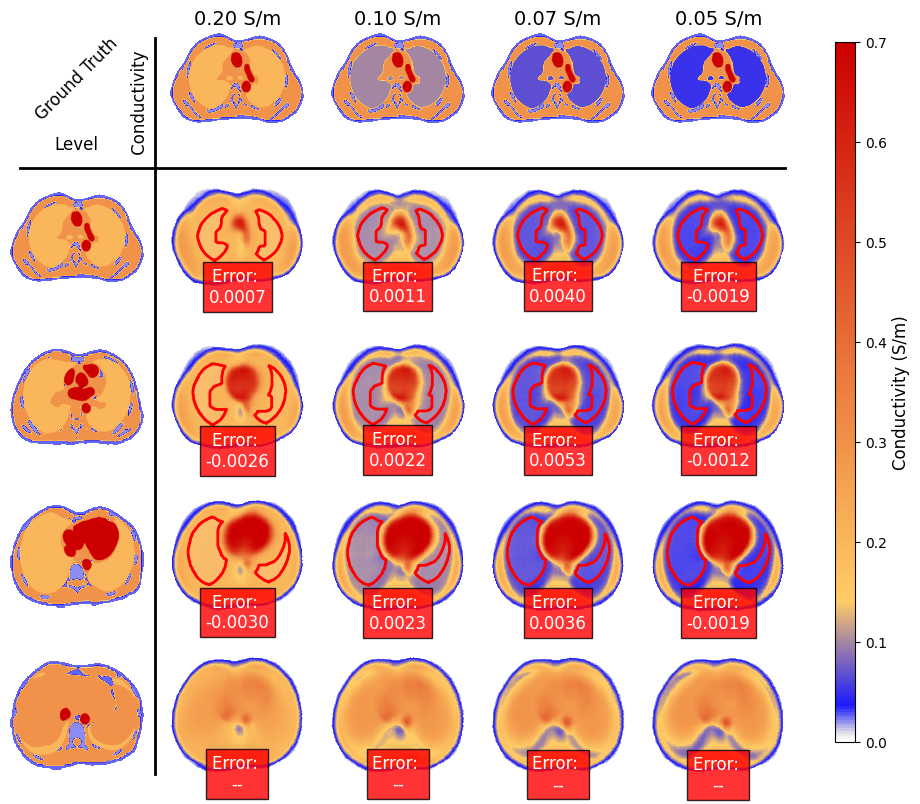

In [112]:
nlevel = 4
ncols = nres+1
nrows = nlevel+1
# set up figure
fig, axes = plt.subplots(nrows, ncols, figsize=(int((ncols)*2), int(2*nrows)))
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
axes[0,0].text(0.5, 0.5, 'Ground Truth', ha='center', va='center', rotation=45)
axes[0,0].text(0.5, 0., 'Level', ha='center', va='center', rotation=0)
axes[0,0].text(0.97, 0.3, ' Conductivity', ha='center', va='center', rotation=90)
axes[0,0].axis('off')

for level in range(nlevel):
    # GT across levels (choose cond. 0.05)
    t = remove_empty_space(targets_case[0,level])
    axes[level+1,0].imshow(t, vmin=0, vmax=0.7, cmap=cmap)       
    axes[level+1,0].axis('off')
    for res in range(nres):
        cond_value = np.mean(targets_case[res,level][lung_masks_case[i,level]==1])
        # GT across cond. values (choose level 0)
        if level == 0:
            t = remove_empty_space(targets_case[res,level])
            axes[0,res+1].imshow(t, vmin=0, vmax=0.7, cmap=cmap)       
            axes[0,res+1].axis('off')
            axes[level,int(res+1)].set_title(f'{cond_value:.2f} S/m')
        p, m = remove_empty_space(preds_case[res,level], lung_masks_case[res,level])
        axes[level+1,res+1].imshow(p, vmin=0, vmax=0.7, cmap=cmap)
        axes[level+1,res+1].imshow(m, cmap='Greys', alpha=0.1)
        axes[level+1,res+1].axis('off')
        plot_lung_contour(p, m, cond_value, axes[level+1,res+1])

        axes[level+1,res+1].axis('off')
        axes[level+1,res+1].set_facecolor('grey')

# Add colorbar to the figure
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(0, 0.7)
cbar = fig.colorbar(sm, cax=cbar_ax)        
cbar.set_label('Conductivity (S/m)')

# Draw horizontal and vertical lines separating the lower right 4x4 grid
# Use the figure's add_artist method to add lines at the required positions
# Get the positions of the first row and first column of the lower right 4x4 grid
top_left_of_4x4 = axes[1, 1].get_position() 
bottom_right_of_4x4 = axes[nrows-1, ncols-1].get_position()

# Adjusted positions for the lines to be outside the plots
horizontal_line_y = top_left_of_4x4.y1 + 0.0
vertical_line_x = top_left_of_4x4.x0 - 0.0

# Draw a horizontal line
fig.add_artist(plt.Line2D([top_left_of_4x4.x0-0.15, bottom_right_of_4x4.x1], 
                        [horizontal_line_y+0.02, horizontal_line_y+0.02], 
                        color='black', linewidth=2))

# Draw a vertical line
fig.add_artist(plt.Line2D([vertical_line_x-0.015, vertical_line_x-0.015], 
                        [bottom_right_of_4x4.y0, top_left_of_4x4.y1+0.15], 
                        color='black', linewidth=2))
                        
# fig.suptitle(f'{test_dataset.cases[int(i/4)]}', fontsize=fontsize)
# plt.tight_layout()
plt.show()
plt.close(fig)


# 3D Properties

In [32]:
n_z_levels = 128
points_level_new = points.reshape(-1, 512, 512, 3)[0]
z_pred = []
z_levels = torch.linspace(1, -1, n_z_levels)
points_level_new = points_level_new.unsqueeze(0)

In [33]:
preds = []
targets = []
points = points  

for z in z_levels:
    points_level_new[:,:,:,2] = z
    _, pred, _ = testing(model, [signals_case[3].unsqueeze(0).float(), 
                              electrodes_case[3].unsqueeze(0).float(), 
                              points_level_new.unsqueeze(0).float()], 
                              batch_size=1, device=cfg.learning.training.device, wandb_log=False,)
    preds.append(pred.detach().cpu().squeeze())
preds = torch.concatenate(preds, axis=0)

In [34]:
preds = preds.reshape(n_z_levels, 512, 512).numpy()

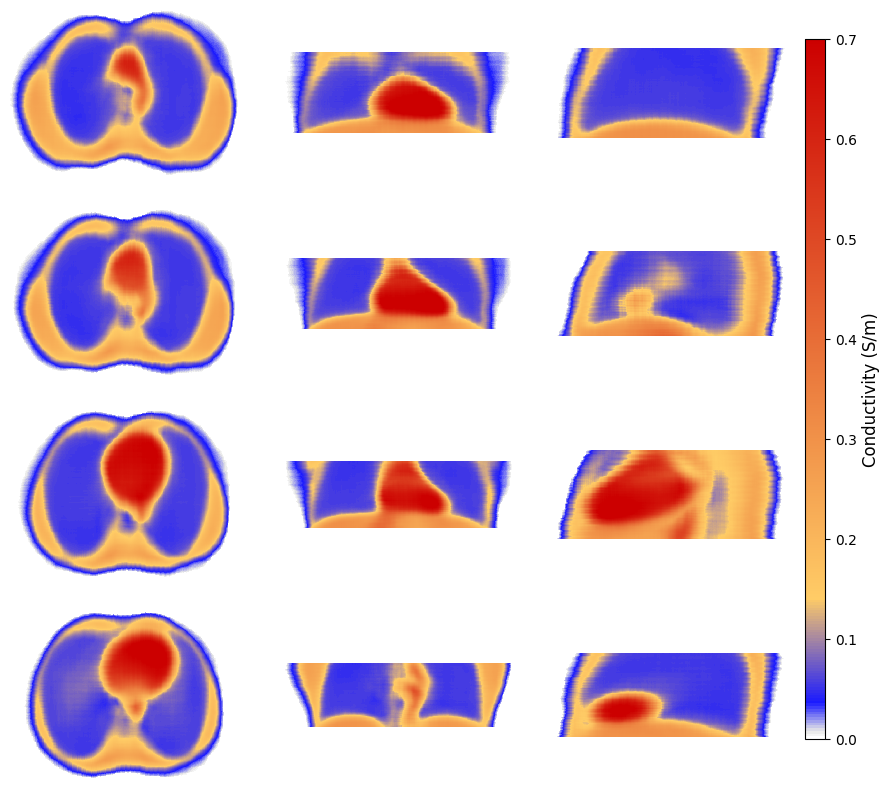

In [40]:
slices_axial = [16, 32, 64, 96]
slices_coronal = [192, 224, 256, 320]
slices_sagital = [128, 192, 256, 320]

ncols = 3 # axial, sagital, coronal
nrows = len(slices_axial) # number of slices

# set up figure
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]

for i in range(len(slices_axial)):
    tmp = remove_empty_space(preds[slices_axial[i]])
    axes[i,0].imshow(tmp, vmin=0, vmax=0.7, cmap=cmap)
    axes[i,0].axis('off')
    tmp = remove_empty_space(preds[:,slices_coronal[i]])
    axes[i,1].imshow(tmp, vmin=0, vmax=0.7, cmap=cmap)
    axes[i,1].axis('off')
    tmp = remove_empty_space(preds[:,:,slices_sagital[i]])
    axes[i,2].imshow(tmp, vmin=0, vmax=0.7, cmap=cmap)
    axes[i,2].axis('off')

# Add colorbar to the figure
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(0, 0.7)
cbar = fig.colorbar(sm, cax=cbar_ax)        
cbar.set_label('Conductivity (S/m)')


In [58]:
targets_case.shape

(4, 4, 512, 512)

## Interploation between Signals

In [78]:
targets = targets_case_raw.reshape(4, 15, 512, 512)

In [79]:
preds_all = []
targets_all = []
# interpolation properties
n_interpolation_levels = 8
interpolation_range = np.linspace(0, 1, n_interpolation_levels)
gt_res = np.array([5, 10, 15, 20])
conductivity = []

for interp in interpolation_range:
    for i in range(3):
        signals_interpolated = signals_case[i] + (signals_case[i+1] - signals_case[i]) * interp
        _, pred, _ = testing(model, [signals_interpolated.unsqueeze(0).float(), 
                                electrodes_case[0].unsqueeze(0).float(), 
                                points_case[0].unsqueeze(0).float()], 
                                batch_size=1, device=cfg.learning.training.device, wandb_log=False,)
        targets_all.append(targets[0].squeeze())
        preds_all.append(pred.detach().cpu().squeeze())
        conductivity.append(1/(gt_res[i] + (gt_res[i+1] - gt_res[i]) * interp))
preds_all = torch.concatenate(preds_all, axis=0)


In [80]:
targets_all = np.concatenate(targets_all, axis=0)


In [81]:
targets_all.shape

(360, 512, 512)

In [82]:
preds_all.shape

torch.Size([360, 512, 512])

In [83]:
conductivity = np.array(conductivity).reshape(n_interpolation_levels, 3)
conductivity = np.moveaxis(conductivity, 0, -1)
conductivity = conductivity.reshape(-1)

In [86]:
resolution = 512
preds = preds_all.reshape(n_interpolation_levels, -1, 15, resolution, resolution).moveaxis(0, 1).reshape(-1, 15, resolution, resolution)
targets = targets_all.reshape(n_interpolation_levels, -1, 15, resolution, resolution)
targets = np.moveaxis(targets, 0, 1).reshape(-1, 15, resolution, resolution)
lung_mask = targets==0.2
lung_mask = lung_mask.reshape(-1, resolution, resolution)
lung_mask_shrunken = torch.tensor([binary_erosion(mask, structure=np.ones((30,30))).astype(np.uint8) for mask in lung_mask])
lung_mask_shrunken = lung_mask_shrunken.reshape(preds.shape)

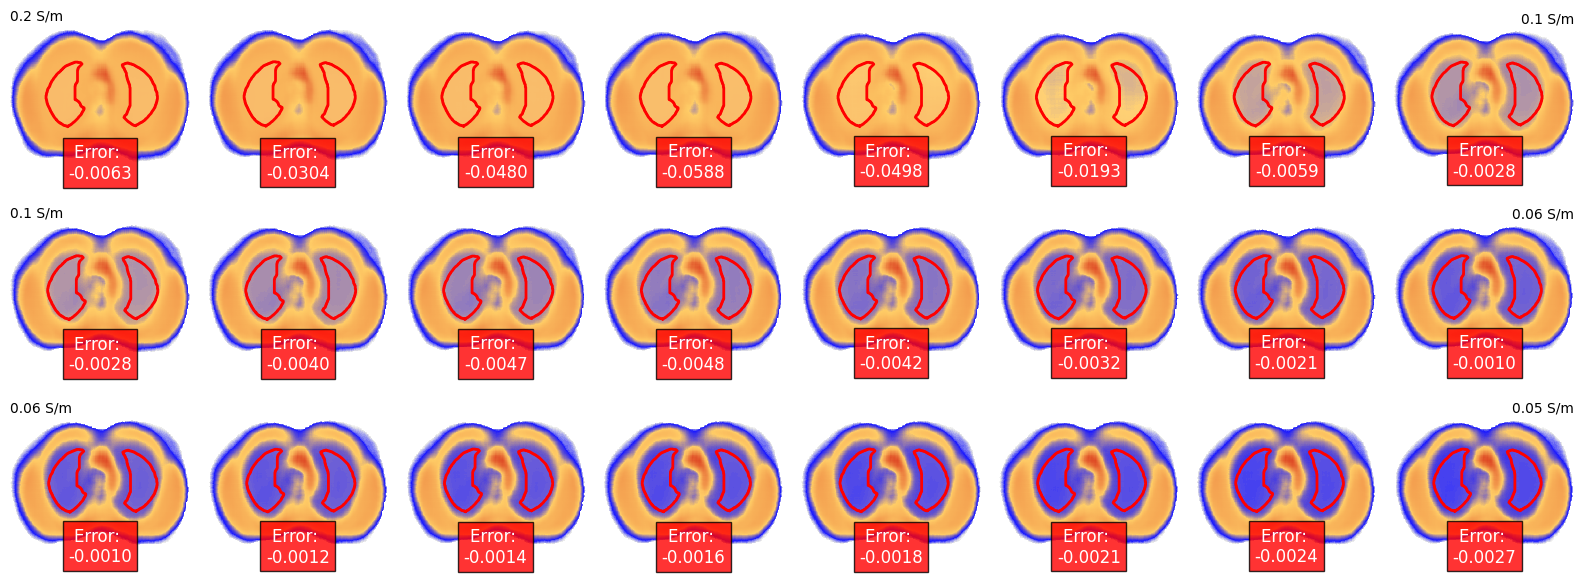

In [89]:
fig, axes = plt.subplots(3, int(n_interpolation_levels), figsize=(int(2*(n_interpolation_levels)), 6))
for i, ax in enumerate(axes.flatten()):
    p, l = remove_empty_space(preds[i,0].numpy(), lung_mask_shrunken[i,0].numpy())
    ax.imshow(p, cmap=cmap, vmin=0, vmax=0.7)
    ax.imshow(l, cmap='Greys', alpha=0.1)
    if i == 0:
        ax.set_title('0.2 S/m', fontsize=10, loc='left')
    elif i == len(interpolation_range)-1:
        ax.set_title('0.1 S/m', fontsize=10, loc='right')
    elif i == len(interpolation_range):
        ax.set_title('0.1 S/m', fontsize=10, loc='left')
    elif i == 2*len(interpolation_range)-1:
        ax.set_title('0.06 S/m', fontsize=10, loc='right')
    elif i == 2*len(interpolation_range):
        ax.set_title('0.06 S/m', fontsize=10, loc='left')
    elif i == 3*len(interpolation_range)-1:
        ax.set_title('0.05 S/m', fontsize=10, loc='right')
    ax.axis('off')
    plot_lung_contour(p, l, conductivity[i], ax=ax)
plt.tight_layout()

In [93]:
len(test_dataset.cases)

30

In [ ]:
preds_case, targets_case, lung_masks_case = pred_postprocess(preds_all, targets_all, resolution=512, nres=nres, nlevel=nlevel)
preds_case, targets_case, lung_masks_case = preds_case.squeeze(0), targets_case.squeeze(0), lung_masks_case.squeeze(0)

In [ ]:
n_interpolation_levels = 48
interpolation_range = np.linspace(0, 1, n_interpolation_levels)
preds = []
for interp in interpolation_range:
    signals_interpolated = signals[0] + (signals[3] - signals[0]) * interp
    # signals_interpolated = interpolate_arrays(signals, interp).unsqueeze(0)
    _, pred = testing(model, [signals_interpolated.unsqueeze(0).float(), 
                                electrodes[0].unsqueeze(0).float(), 
                                points[0].unsqueeze(0).float()], 
                                batch_size=1, device=cfg.learning.training.device, wandb_log=False,
                                downsample_factor_test=downsample_factor)
    pred = pred.detach().cpu().numpy().squeeze().reshape(4, down_resolution, down_resolution)
    preds.append(pred)

# Get Coordinate Boundaries

In [ ]:
points = []
max_x = 0
max_y = 0
max_z = 0
min_x = 0
min_y = 0
min_z = 0

for case in tqdm(test_dataset):
    points = case[0]
    points = points[case[4].reshape(-1) != 0]
    max_x = max(max_x, torch.max(points[:,0]))
    max_y = max(max_y, torch.max(points[:,1]))
    max_z = max(max_z, torch.max(points[:,2]))
    min_x = min(min_x, torch.min(points[:,0]))
    min_y = min(min_y, torch.min(points[:,1]))
    min_z = min(min_z, torch.min(points[:,2]))
for case in tqdm(val_dataset):
    points = case[0]
    points = points[case[4].reshape(-1) != 0]
    max_x = max(max_x, torch.max(points[:,0]))
    max_y = max(max_y, torch.max(points[:,1]))
    max_z = max(max_z, torch.max(points[:,2]))
    min_x = min(min_x, torch.min(points[:,0]))
    min_y = min(min_y, torch.min(points[:,1]))
    min_z = min(min_z, torch.min(points[:,2]))
for case in tqdm(train_dataset):
    points = case[0]
    points = points[case[4].reshape(-1) != 0]
    max_x = max(max_x, torch.max(points[:,0]))
    max_y = max(max_y, torch.max(points[:,1]))
    max_z = max(max_z, torch.max(points[:,2]))
    min_x = min(min_x, torch.min(points[:,0]))
    min_y = min(min_y, torch.min(points[:,1]))
    min_z = min(min_z, torch.min(points[:,2]))

print(max_x, max_y, max_z, min_x, min_y, min_z)